# Pytorch-Lightning Generative Adversarial Network Example

In [1]:
import os

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Define Model

### 1.1 pytorch_lightning.LightningModule

- [LIGHTNING MODULE](<https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html#lightningmodule>)
- Required Methods
    - **forward()**: defines the prediction/inference actions.
    - **training_step()**: defined the train loop. Independent of forward.
    - **configure_optimizers()**: define optimizer.
- To validate and test the model, define below methods
    - **validation_step()**
    - **test_step()**

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(img_shape))),  # np.prod(element): product of array elements
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img
    

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity
    
    
class GAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim = 100,
        lr = 0.0002,
        **kwargs
    ):
        super().__init__()
        # with it, you can use all arguments like this: self.hparams.width
        self.save_hyperparameters()

        data_shape = (channels, width, height)
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=data_shape)
        self.discriminator = Discriminator(img_shape=data_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):  # use optimizer_idx to choose training option
        imgs, _ = batch

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)  # num of images(imgs.shape[0]) * latent_dim
        z = z.type_as(imgs) # make z type same as imgs

        # train generator
        if optimizer_idx == 0:
            self.generated_imgs = self(z)

            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)  # make valid type same as imgs

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)

            return g_loss

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            fake_loss = self.adversarial_loss(
                self.discriminator(self(z).detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            
            return d_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []  # first list: optimizer(<- optimizer_idx), second list: lr_scheduler

    def on_epoch_end(self):
        if (self.current_epoch % 10) == 0:
        
            z = self.validation_z.type_as(self.generator.model[0].weight)

            # log sampled images
            sample_imgs = self(z).detach().numpy()

            plt.figure(figsize=(24, 3))

            for i in range(8):

                plt.subplot(1, 8, i+1)
                plt.imshow(sample_imgs[i].reshape([28, 28]))

            plt.show()
        
        

## 2. Load Trainset

In [3]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

## 3. Initialize and Train Model

### 3.1 pytorch_lightning.Trainer() parameters

- Machine
    - **num_processes**: number of processes for distributed training with
    - **gpus**: number of gpus to train on (int) or which GPUs to train on (list or str) applied per node
    - **num_nodes**: number of gpu nodes
- Training
    - **max_epochs**: max epochs, default 1000 
    - **min_epochs**: min epochs, default 1
    - **max_steps**: max steps, default None
    - **min_steps**: min steps, default None
- Validation
    - **val_check_interval**: Check val every n train epochs.
    - **num_sanity_val_steps**: number of sanity check trials. To use all validation sets, set it -1
- Save
    - **default_root_dir**: path for logs and checkpoints. Default `os.getcwd()`
    - **callbacks**(Union[List[Callback], Callback, None]): Add a callback or list of callbacks.
    - **checkpoint_callback**(bool): If True, enable checkpointing. It will configure a default

### 3.2 pytorch.lightning.Trainer() methods

- **fit**(model, train_dataloader=None, val_dataloaders=None, datamodule=None)
- **predict**(model=None, dataloaders=None, datamodule=None, return_predictions=None)
- **test**(model=None, test_dataloaders=None, ckpt_path='best', verbose=True, datamodule=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 481 K 
1 | discriminator | Discriminator | 533 K 
------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.059     Total estimated model params size (MB)


Epoch 0:   0%|          | 4/938 [00:00<00:34, 27.16it/s, loss=0.679, v_num=21]

/Users/woo/.pyenv/versions/3.8.2/envs/tutorial-lightning/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0: 100%|██████████| 938/938 [00:26<00:00, 35.94it/s, loss=0.783, v_num=21]

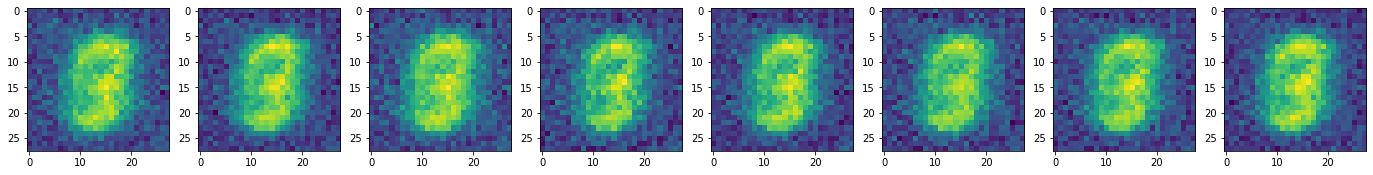

Epoch 10: 100%|██████████| 938/938 [00:27<00:00, 33.78it/s, loss=2.67, v_num=21]

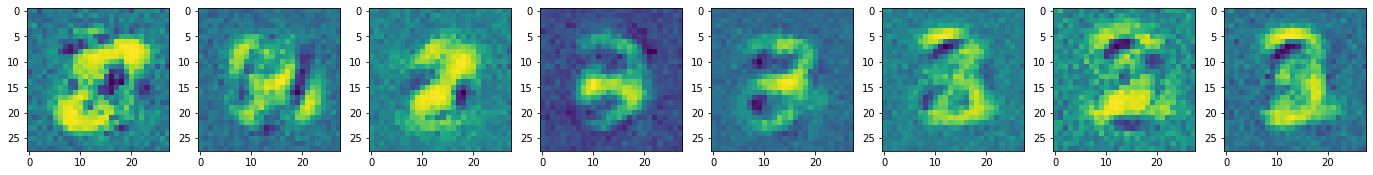

Epoch 20: 100%|██████████| 938/938 [00:28<00:00, 32.71it/s, loss=3.16, v_num=21]

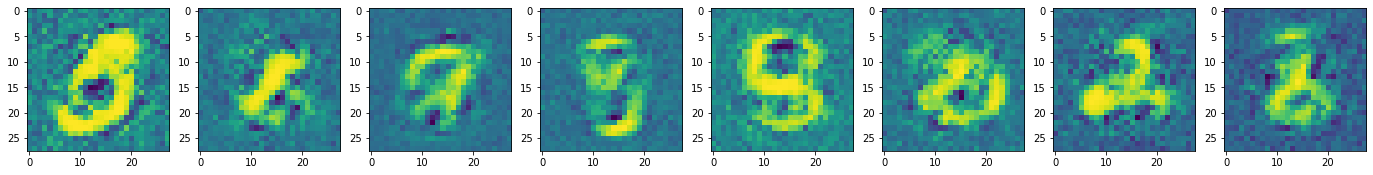

Epoch 30: 100%|██████████| 938/938 [00:30<00:00, 30.95it/s, loss=3.35, v_num=21]

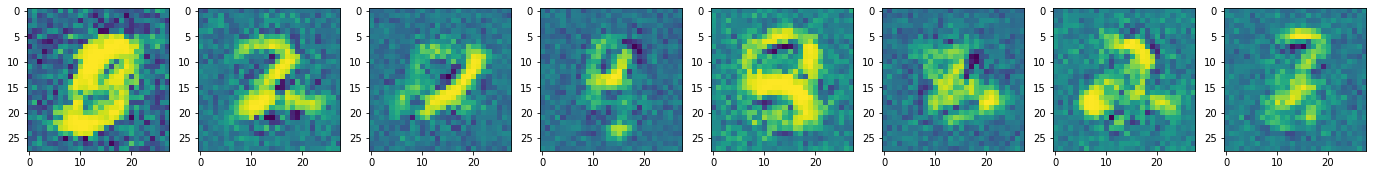

Epoch 40: 100%|██████████| 938/938 [00:28<00:00, 33.49it/s, loss=3.35, v_num=21]

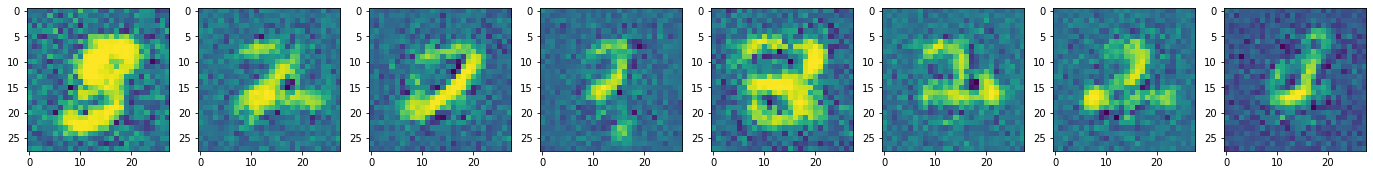

Epoch 50: 100%|██████████| 938/938 [00:26<00:00, 35.28it/s, loss=3.87, v_num=21]

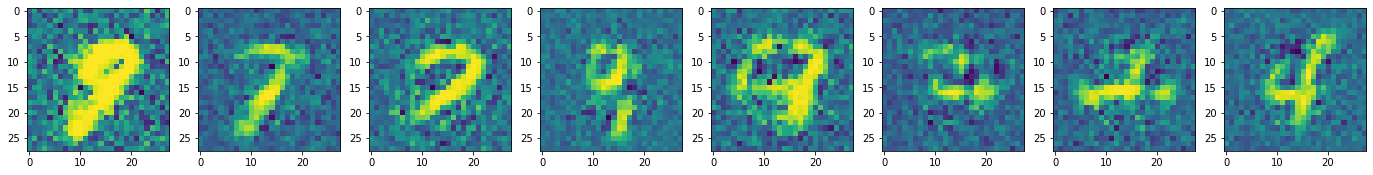

Epoch 60: 100%|██████████| 938/938 [00:30<00:00, 30.74it/s, loss=3.87, v_num=21]

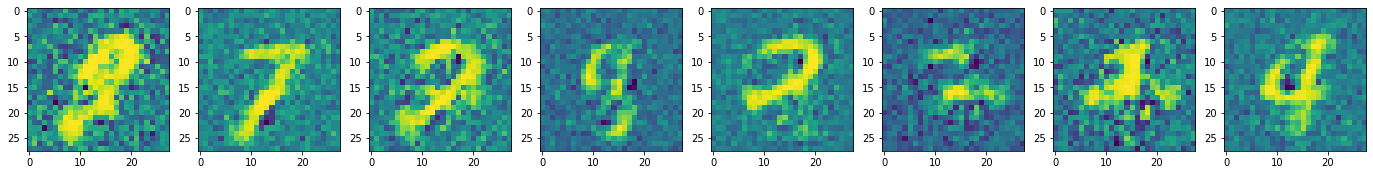

Epoch 70: 100%|██████████| 938/938 [00:30<00:00, 30.33it/s, loss=4.46, v_num=21]

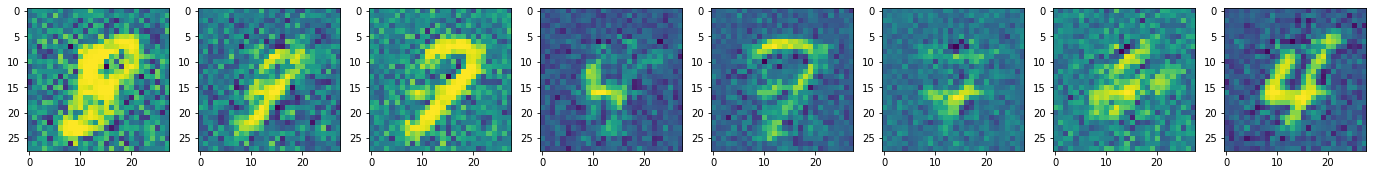

Epoch 80: 100%|██████████| 938/938 [00:24<00:00, 38.07it/s, loss=4.3, v_num=21] 

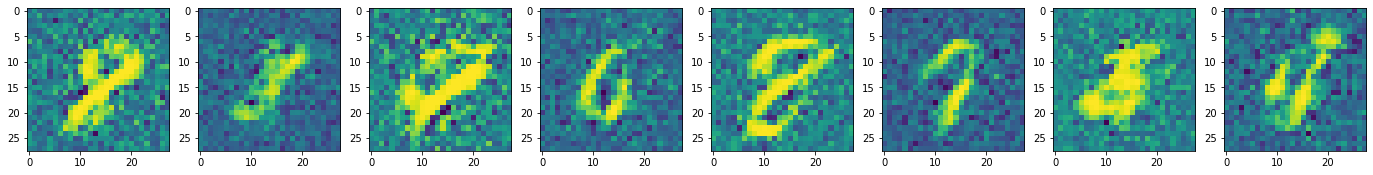

Epoch 90: 100%|██████████| 938/938 [00:24<00:00, 37.88it/s, loss=4.58, v_num=21]

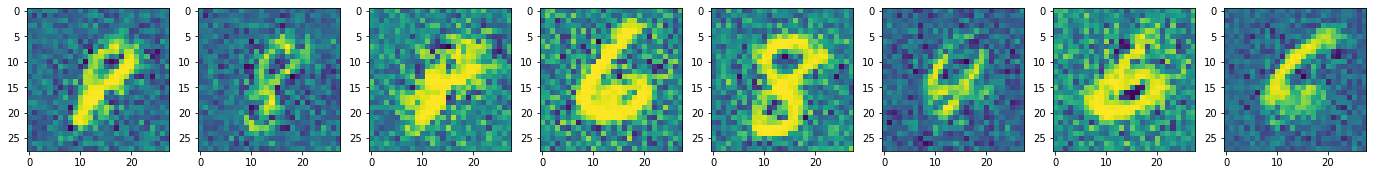

Epoch 99: 100%|██████████| 938/938 [00:24<00:00, 37.80it/s, loss=4.88, v_num=21]


In [4]:
model = GAN(1,28,28)

trainer = pl.Trainer(
    num_processes=1,
    max_epochs=100,
    default_root_dir=os.getcwd(),
    checkpoint_callback=False,  # if False, does not store checkpoint
    progress_bar_refresh_rate=1,  # do not show tqdm progress bar
)

trainer.fit(model, train_loader)